Prepare Original Data

In [1]:
import csv
import os
from typing import List, Dict

# Set CUDA device
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

def process_csv_data(file_path: str) -> List[Dict]:
    """
    Process the CSV data and transform it into a list of dictionaries.
    
    Args:
        file_path (str): Path to the CSV file
        
    Returns:
        List[Dict]: List of processed data dictionaries
    """
    processed_data = []
    
    # Define column headers
    headers = [
        'age', 'workclass', 'fnlwgt', 'education', 'education-num',
        'marital-status', 'occupation', 'relationship', 'race', 'sex',
        'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
        'income'
    ]
    
    with open(file_path, 'r') as file:
        csv_reader = csv.reader(file)
        next(csv_reader)  # Skip header row
        
        for row in csv_reader:
            # Create dictionary from row data
            data_dict = dict(zip(headers, row))
            
            # Rename keys and vals for better learning for the model
            data_dict['school-year'] = data_dict.pop('education-num')
            data_dict['investment-loss'] = data_dict.pop('capital-loss')
            
            if data_dict['income'] == '<=50K':
                data_dict['income'] = 'less than or equal to 50K'
            elif data_dict['income'] == '>50K':
                data_dict['income'] = 'greater than 50K'
                
            processed_data.append(data_dict)
    
    return processed_data

# Process the data
processed_row = process_csv_data('adult100.csv')

# Display first row for verification
print(processed_row[0])


{'age': '39', 'workclass': 'State-gov', 'fnlwgt': '77516', 'education': 'Bachelors', 'marital-status': 'Never-married', 'occupation': 'Adm-clerical', 'relationship': 'Not-in-family', 'race': 'White', 'sex': 'Male', 'capital-gain': '2174', 'hours-per-week': '40', 'native-country': 'United-States', 'income': 'less than or equal to 50K', 'school-year': '13', 'investment-loss': '0'}


Construct Trainset

In [2]:
# Import required libraries
from transformers import GPT2LMHeadModel, GPT2Tokenizer, DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments
import torch
import json
from torch.utils.data import Dataset

# Initialize tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('distilgpt2')
tokenizer.pad_token = tokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained('distilgpt2')

class AdultDataset(Dataset):
    """
    Custom dataset class for adult data processing.
    
    Args:
        data (list): List of processed data dictionaries
        tokenizer: GPT2 tokenizer instance
    """
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        """
        Process a single data point into model inputs.
        
        Args:
            idx (int): Index of the data point
            
        Returns:
            dict: Dictionary containing input_ids, attention_mask and labels
        """
        # Convert dictionary to formatted JSON string
        text = json.dumps(self.data[idx], ensure_ascii=False, sort_keys=True)
        
        # Encode text with tokenizer
        encodings = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=150,
            return_tensors='pt'
        )
        
        # Create attention mask
        attention_mask = torch.ones_like(encodings['input_ids'])
        attention_mask[encodings['input_ids'] == tokenizer.pad_token_id] = 0 # mask = 0 for padding
        encodings['attention_mask'] = attention_mask
        
        # Create labels (same as input_ids for language model training)
        encodings['labels'] = encodings['input_ids'].clone()
        
        return encodings

# Create training dataset
train_dataset = AdultDataset(processed_row, tokenizer)
print(f"Training dataset size: {len(train_dataset)}")

# Create data collator for language modeling
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # Disable masked language modeling
)

Training dataset size: 100


Training

Step,Training Loss
10,2.202800
20,0.946500
30,0.530200
40,0.417500
50,0.349900
60,0.324100
70,0.300100
80,0.310700
90,0.296800
100,0.286100


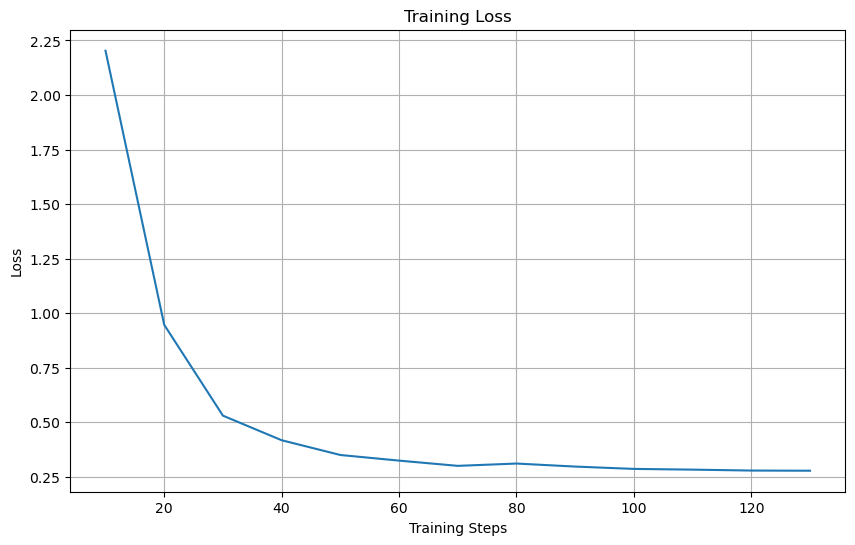

('./gpt2-adult-data-final/tokenizer_config.json',
 './gpt2-adult-data-final/special_tokens_map.json',
 './gpt2-adult-data-final/vocab.json',
 './gpt2-adult-data-final/merges.txt',
 './gpt2-adult-data-final/added_tokens.json')

In [3]:
# Configure training parameters
training_args = TrainingArguments(
    output_dir="./gpt2-adult-data",
    overwrite_output_dir=True,
    num_train_epochs=10,
    per_device_train_batch_size=8,
    save_steps=100,
    save_total_limit=2,
    logging_dir='./logs',  # Directory for logging
    logging_steps=10,      # Log loss every 10 steps
    learning_rate=5e-5,    # Learning rate
    weight_decay=0.01
)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
)

# Start training
train_result = trainer.train()

# Visualize training loss
import pandas as pd
import matplotlib.pyplot as plt

# Load training logs
log_history = pd.DataFrame(trainer.state.log_history)
train_loss = log_history[log_history['loss'].notna()]

# Plot loss curve
plt.figure(figsize=(10, 6))
plt.plot(train_loss['step'], train_loss['loss'])
plt.title('Training Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Save model and tokenizer
model.save_pretrained("./gpt2-adult-data-final")
tokenizer.save_pretrained("./gpt2-adult-data-final")

Generate Data

In [4]:
from transformers import GPT2LMHeadModel

# Load model and tokenizer
model = GPT2LMHeadModel.from_pretrained("./gpt2-adult-data-final")
tokenizer = GPT2Tokenizer.from_pretrained("./gpt2-adult-data-final")

# Configure generation parameters
input_text = '{"'
input_ids = tokenizer.encode(input_text, return_tensors='pt')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_ids = input_ids.to(device)
model = model.to(device)

# Generate synthetic data
output = model.generate(
    input_ids,
    max_length=150,
    num_return_sequences=200,
    no_repeat_ngram_size=3,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    temperature=0.8,
    pad_token_id=tokenizer.eos_token_id,
    attention_mask=torch.ones_like(input_ids)  # Add attention mask for better generation
)

# Convert generated sequences to text and store in list
generated_texts = []
for i in range(len(output)):
    text = tokenizer.decode(output[i], skip_special_tokens=True)
    generated_texts.append(text)

# Save generated texts to JSON file
import json
with open('generated_rows.json', 'w', encoding='utf-8') as f:
    json.dump(generated_texts, f, ensure_ascii=False, indent=4)

print("Generated texts have been saved to generated_rows.json")


Generated texts have been saved to generated_rows.json


Parsing Generated Data

In [5]:
import json
import re
import pandas as pd

def parse_generated_data():
    """
    Parse and clean the generated JSON data, convert it to DataFrame,
    and save as CSV file.
    """
    # Read generated JSON file
    with open('generated_rows.json', 'r', encoding='utf-8') as f:
        generated_texts = json.load(f)

    # Store valid JSON objects
    complete_json = []

    # Process each generated text
    for text in generated_texts:
        # Find all JSON objects using non-greedy matching
        matches = re.findall(r'{.*?}', text, re.DOTALL)
        
        if matches:
            match = matches[0]
            try:
                # Parse JSON
                json_obj = json.loads(match)
                
                # Convert field names to original format
                if 'school-year' in json_obj:
                    json_obj['education-num'] = json_obj.pop('school-year')
                if 'investment-loss' in json_obj:
                    json_obj['capital-loss'] = json_obj.pop('investment-loss')
                if 'income' in json_obj:
                    if json_obj['income'] == 'less than or equal to 50K':
                        json_obj['income'] = '<=50K'
                    elif json_obj['income'] == 'greater than 50K':
                        json_obj['income'] = '>50K'
                
                # Convert numeric fields to integers
                numeric_fields = ['age', 'fnlwgt', 'education-num', 'capital-gain', 
                                'capital-loss', 'hours-per-week']
                has_invalid_numeric = False
                
                for field in numeric_fields:
                    if field in json_obj:
                        try:
                            json_obj[field] = int(json_obj[field])
                        except (ValueError, TypeError):
                            has_invalid_numeric = True
                            break
                
                if has_invalid_numeric:
                    continue
                
                # Check for required fields
                required_keys = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
                               'marital-status', 'occupation', 'relationship', 'race', 'sex',
                               'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
                               'income']
                
                if all(key in json_obj for key in required_keys):
                    complete_json.append(json_obj)
                    
            except json.JSONDecodeError:
                continue

    print(f"\nFound {len(complete_json)} complete JSON objects")

    # Keep only first 100 records
    complete_json = complete_json[:100]
    
    # Save cleaned JSON
    with open('complete_json.json', 'w', encoding='utf-8') as f:
        json.dump(complete_json, f, ensure_ascii=False, indent=4)
    
    print(f"\nSaved {len(complete_json)} complete JSON objects")

    # Convert to DataFrame
    df = pd.DataFrame(complete_json)
    
    # Ensure column order matches original data
    original_columns = pd.read_csv('adult100.csv').columns
    df = df[original_columns]

    # Save as CSV
    df.to_csv('generated_table.csv', index=False)
    print(f"Generated generated_table.csv with {len(df)} records")


parse_generated_data()



Found 180 complete JSON objects

Saved 100 complete JSON objects
Generated generated_table.csv with 100 records


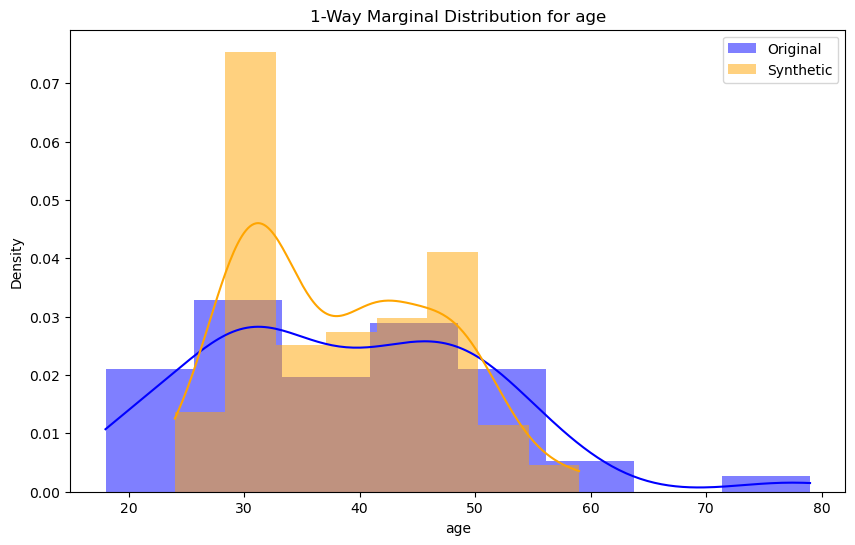


Statistics for age:
Original Data:
18    0.02
19    0.03
20    0.02
21    0.01
22    0.01
23    0.03
24    0.01
25    0.03
27    0.01
28    0.03
29    0.05
30    0.06
31    0.05
32    0.04
33    0.01
34    0.02
35    0.02
36    0.01
37    0.04
38    0.02
39    0.02
40    0.02
41    0.02
42    0.02
43    0.04
44    0.03
45    0.01
46    0.02
47    0.03
48    0.05
49    0.05
50    0.02
52    0.02
53    0.05
54    0.01
56    0.01
57    0.02
59    0.02
76    0.01
79    0.01
Name: age, dtype: float64

Synthetic Data:
24    0.03
27    0.01
28    0.02
29    0.11
30    0.04
31    0.05
32    0.13
33    0.01
34    0.05
35    0.02
37    0.03
39    0.01
40    0.09
41    0.02
42    0.04
43    0.06
44    0.02
45    0.01
47    0.04
48    0.08
49    0.05
50    0.01
52    0.02
53    0.03
59    0.02
Name: age, dtype: float64

Distribution difference:
Mean absolute difference: 0.0175
Maximum difference: 0.0900


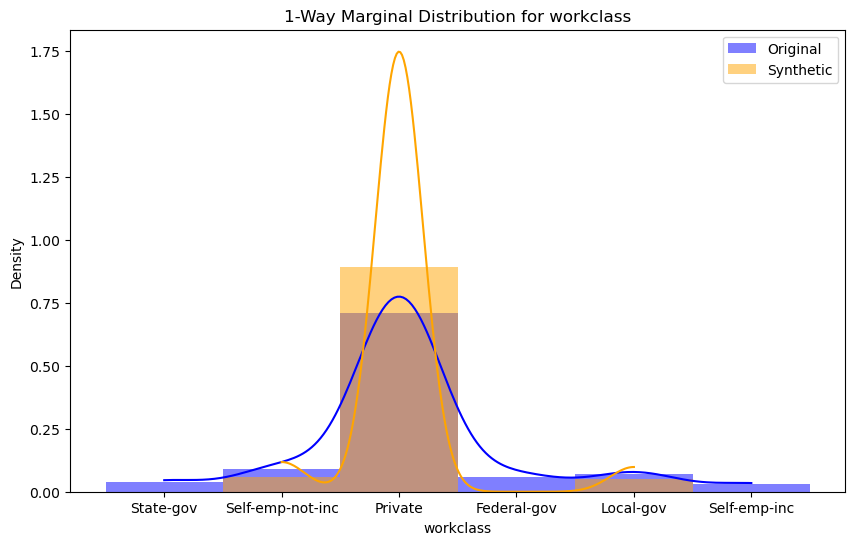


Statistics for workclass:
Original Data:
Federal-gov         0.06
Local-gov           0.07
Private             0.71
Self-emp-inc        0.03
Self-emp-not-inc    0.09
State-gov           0.04
Name: workclass, dtype: float64

Synthetic Data:
Local-gov           0.05
Private             0.89
Self-emp-not-inc    0.06
Name: workclass, dtype: float64

Distribution difference:
Mean absolute difference: 0.0600
Maximum difference: 0.1800


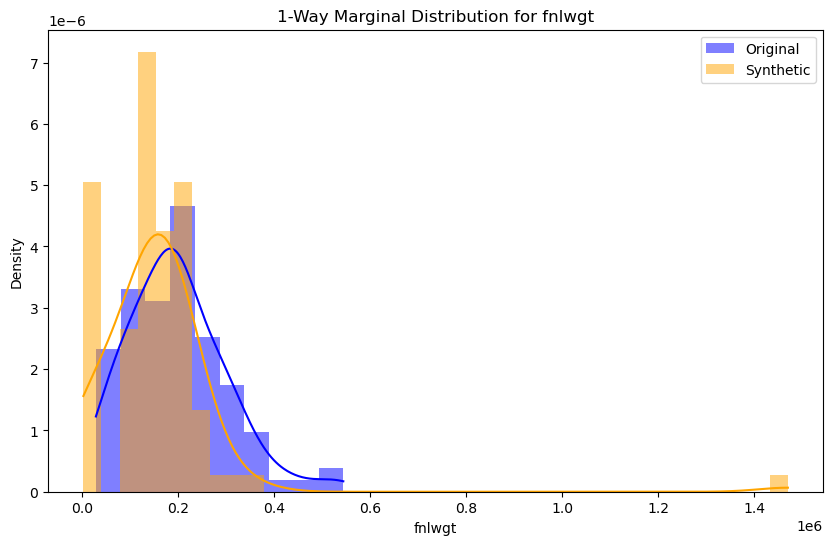


Statistics for fnlwgt:
Original Data:
28887     0.01
32214     0.01
32275     0.01
45781     0.01
51618     0.01
          ... 
386940    0.01
410867    0.01
446839    0.01
507875    0.01
544091    0.01
Name: fnlwgt, Length: 100, dtype: float64

Synthetic Data:
2807       0.01
10906      0.01
12083      0.01
14083      0.01
17898      0.01
           ... 
248710     0.01
285595     0.01
322175     0.01
354149     0.01
1469985    0.01
Name: fnlwgt, Length: 99, dtype: float64

Distribution difference:
Mean absolute difference: 0.0101
Maximum difference: 0.0200


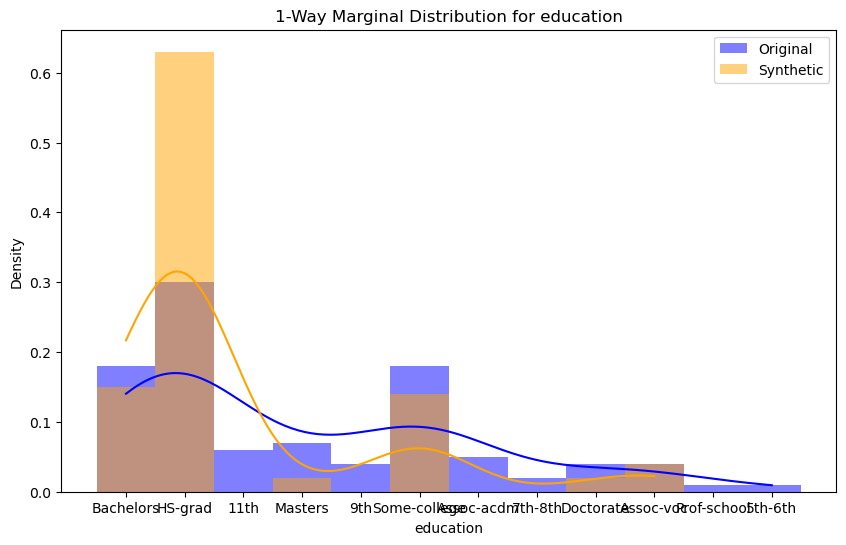


Statistics for education:
Original Data:
11th            0.06
5th-6th         0.01
7th-8th         0.02
9th             0.04
Assoc-acdm      0.05
Assoc-voc       0.04
Bachelors       0.18
Doctorate       0.04
HS-grad         0.30
Masters         0.07
Prof-school     0.01
Some-college    0.18
Name: education, dtype: float64

Synthetic Data:
Assoc-voc       0.04
Bachelors       0.15
Doctorate       0.02
HS-grad         0.63
Masters         0.02
Some-college    0.14
Name: education, dtype: float64

Distribution difference:
Mean absolute difference: 0.0550
Maximum difference: 0.3300


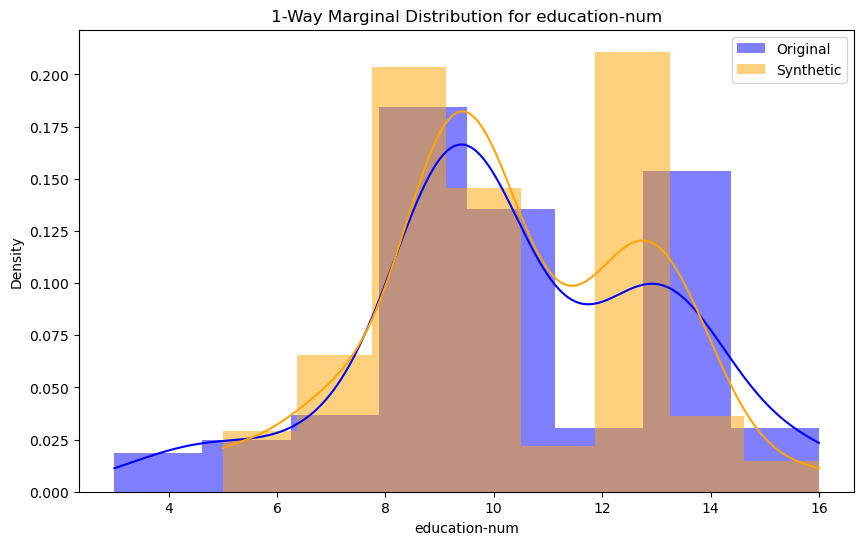


Statistics for education-num:
Original Data:
3     0.01
4     0.02
5     0.04
7     0.06
9     0.30
10    0.18
11    0.04
12    0.05
13    0.18
14    0.07
15    0.01
16    0.04
Name: education-num, dtype: float64

Synthetic Data:
5     0.04
7     0.09
9     0.28
10    0.20
11    0.03
12    0.10
13    0.19
14    0.05
16    0.02
Name: education-num, dtype: float64

Distribution difference:
Mean absolute difference: 0.0183
Maximum difference: 0.0500


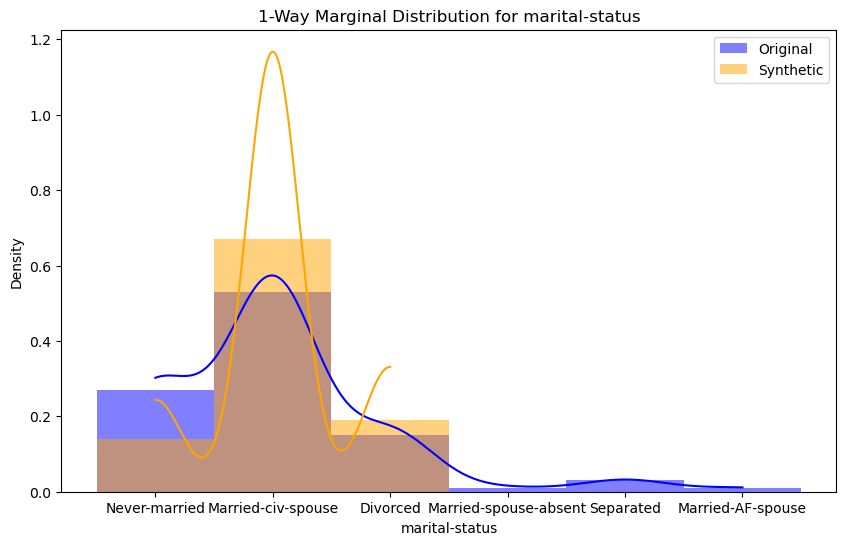


Statistics for marital-status:
Original Data:
Divorced                 0.15
Married-AF-spouse        0.01
Married-civ-spouse       0.53
Married-spouse-absent    0.01
Never-married            0.27
Separated                0.03
Name: marital-status, dtype: float64

Synthetic Data:
Divorced              0.19
Married-civ-spouse    0.67
Never-married         0.14
Name: marital-status, dtype: float64

Distribution difference:
Mean absolute difference: 0.0600
Maximum difference: 0.1400


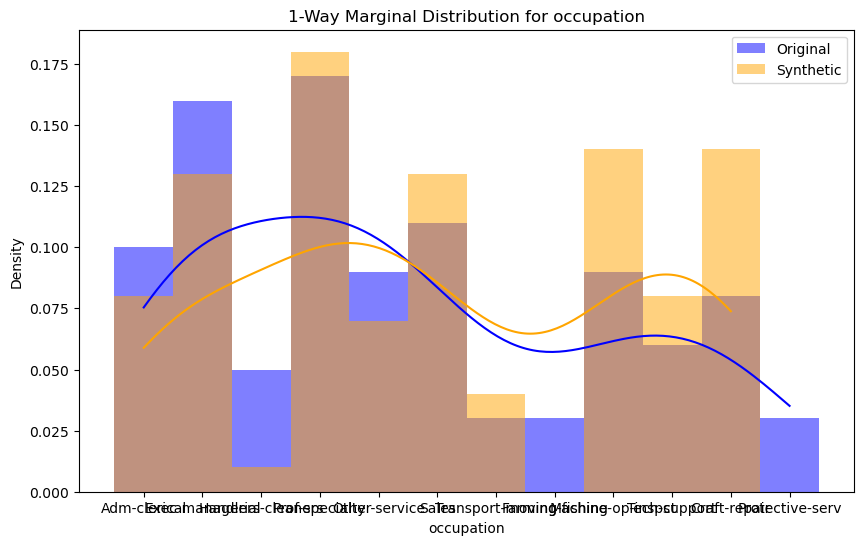


Statistics for occupation:
Original Data:
Adm-clerical         0.10
Craft-repair         0.08
Exec-managerial      0.16
Farming-fishing      0.03
Handlers-cleaners    0.05
Machine-op-inspct    0.09
Other-service        0.09
Prof-specialty       0.17
Protective-serv      0.03
Sales                0.11
Tech-support         0.06
Transport-moving     0.03
Name: occupation, dtype: float64

Synthetic Data:
Adm-clerical         0.08
Craft-repair         0.14
Exec-managerial      0.13
Handlers-cleaners    0.01
Machine-op-inspct    0.14
Other-service        0.07
Prof-specialty       0.18
Sales                0.13
Tech-support         0.08
Transport-moving     0.04
Name: occupation, dtype: float64

Distribution difference:
Mean absolute difference: 0.0283
Maximum difference: 0.0600


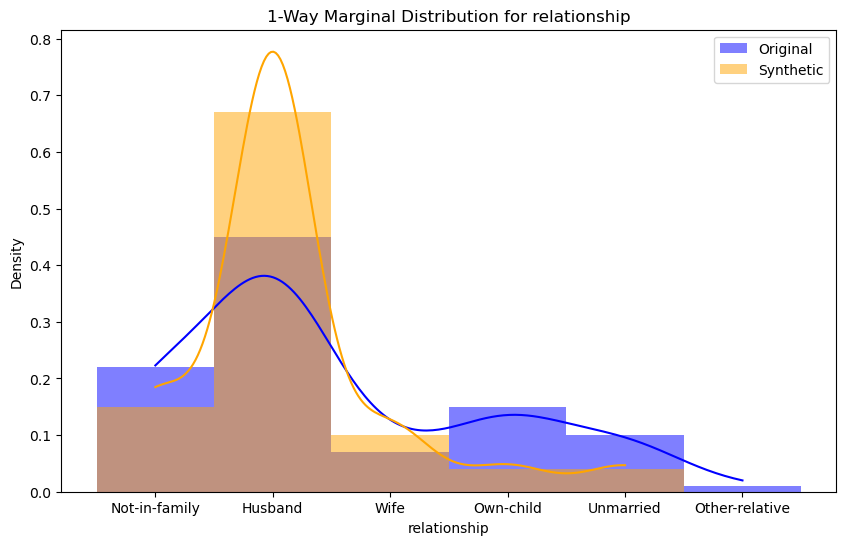


Statistics for relationship:
Original Data:
Husband           0.45
Not-in-family     0.22
Other-relative    0.01
Own-child         0.15
Unmarried         0.10
Wife              0.07
Name: relationship, dtype: float64

Synthetic Data:
Husband          0.67
Not-in-family    0.15
Own-child        0.04
Unmarried        0.04
Wife             0.10
Name: relationship, dtype: float64

Distribution difference:
Mean absolute difference: 0.0833
Maximum difference: 0.2200


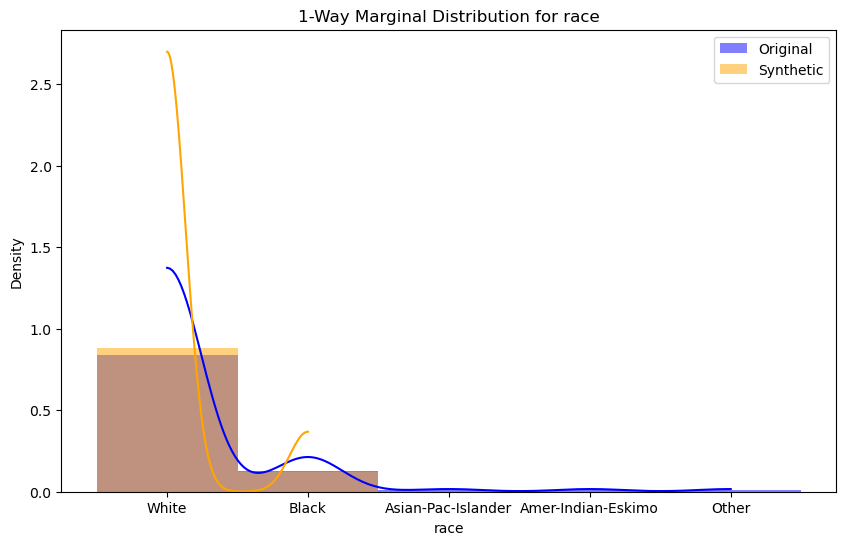


Statistics for race:
Original Data:
Amer-Indian-Eskimo    0.01
Asian-Pac-Islander    0.01
Black                 0.13
Other                 0.01
White                 0.84
Name: race, dtype: float64

Synthetic Data:
Black    0.12
White    0.88
Name: race, dtype: float64

Distribution difference:
Mean absolute difference: 0.0160
Maximum difference: 0.0400


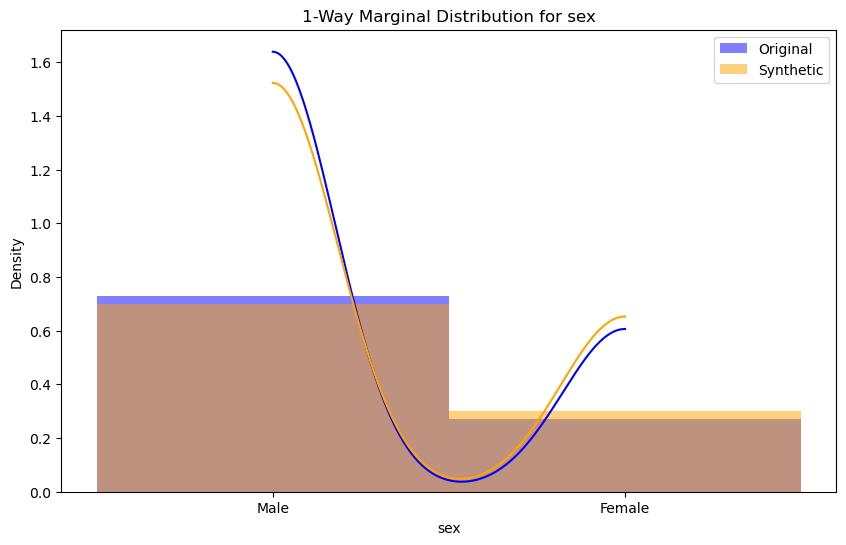


Statistics for sex:
Original Data:
Female    0.27
Male      0.73
Name: sex, dtype: float64

Synthetic Data:
Female    0.3
Male      0.7
Name: sex, dtype: float64

Distribution difference:
Mean absolute difference: 0.0300
Maximum difference: 0.0300


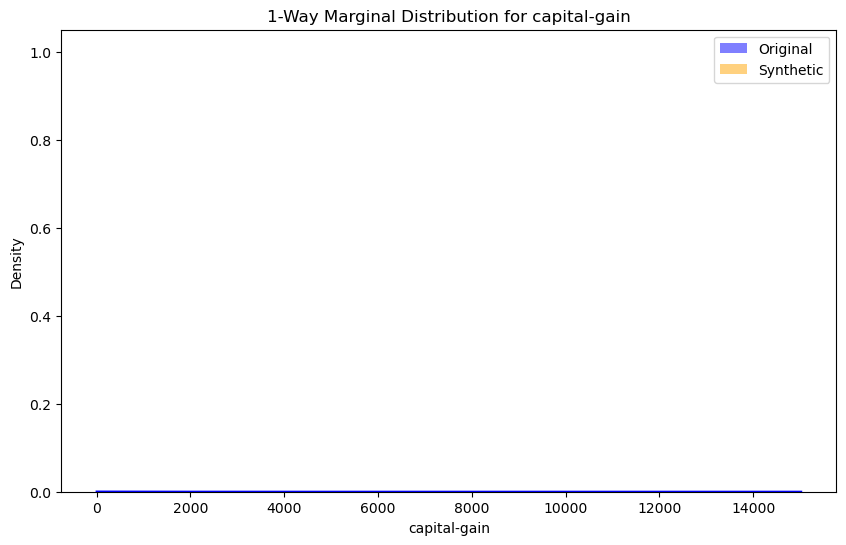


Statistics for capital-gain:
Original Data:
0        0.92
2174     0.01
2407     0.01
5013     0.01
5178     0.01
7688     0.01
14084    0.01
14344    0.01
15024    0.01
Name: capital-gain, dtype: float64

Synthetic Data:
0    1.0
Name: capital-gain, dtype: float64

Distribution difference:
Mean absolute difference: 0.0178
Maximum difference: 0.0800


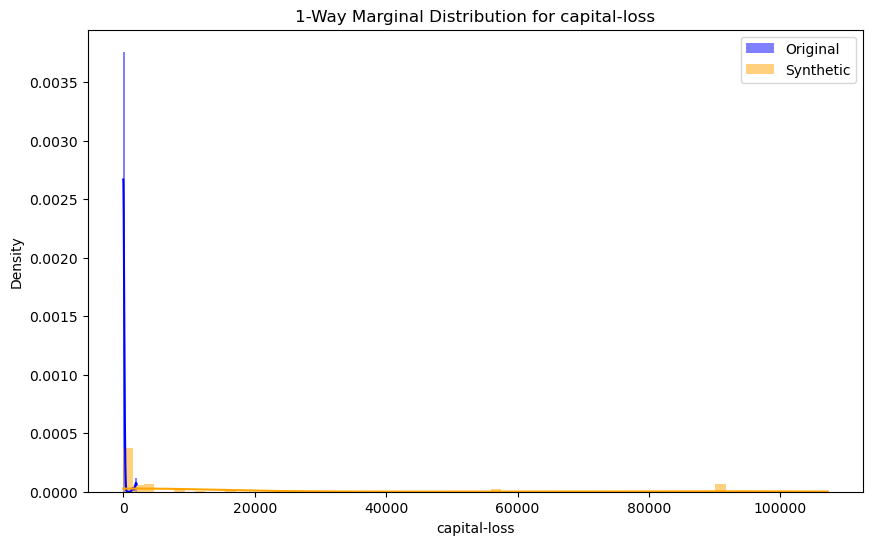


Statistics for capital-loss:
Original Data:
0       0.96
1408    0.01
1902    0.02
2042    0.01
Name: capital-loss, dtype: float64

Synthetic Data:
1         0.06
3         0.01
4         0.02
22        0.02
24        0.03
          ... 
90800     0.01
90872     0.01
90887     0.01
90891     0.01
107201    0.01
Name: capital-loss, Length: 79, dtype: float64

Distribution difference:
Mean absolute difference: 0.0242
Maximum difference: 0.9600


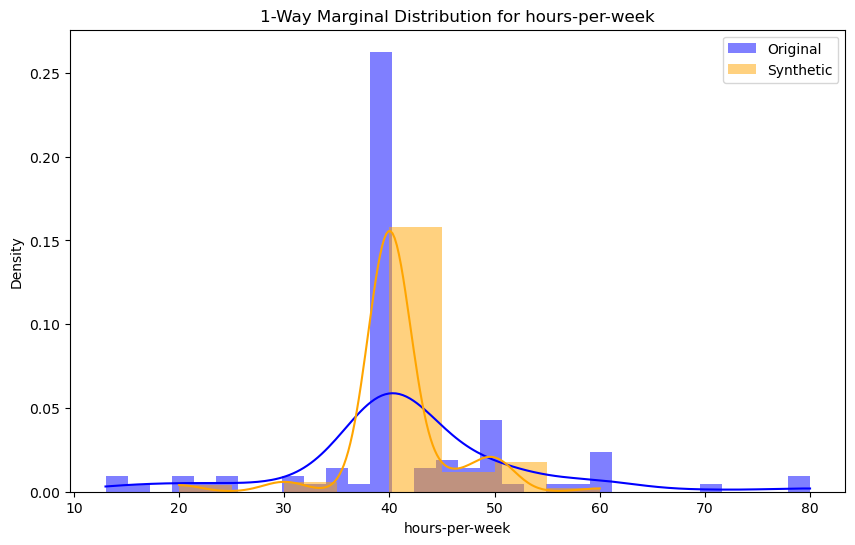


Statistics for hours-per-week:
Original Data:
13    0.01
15    0.01
16    0.01
20    0.02
22    0.01
25    0.02
30    0.02
32    0.01
35    0.03
38    0.01
40    0.55
43    0.02
44    0.01
45    0.04
48    0.03
50    0.09
52    0.01
55    0.01
58    0.01
60    0.05
70    0.01
80    0.02
Name: hours-per-week, dtype: float64

Synthetic Data:
20    0.02
30    0.03
40    0.79
45    0.04
48    0.02
50    0.09
60    0.01
Name: hours-per-week, dtype: float64

Distribution difference:
Mean absolute difference: 0.0227
Maximum difference: 0.2400


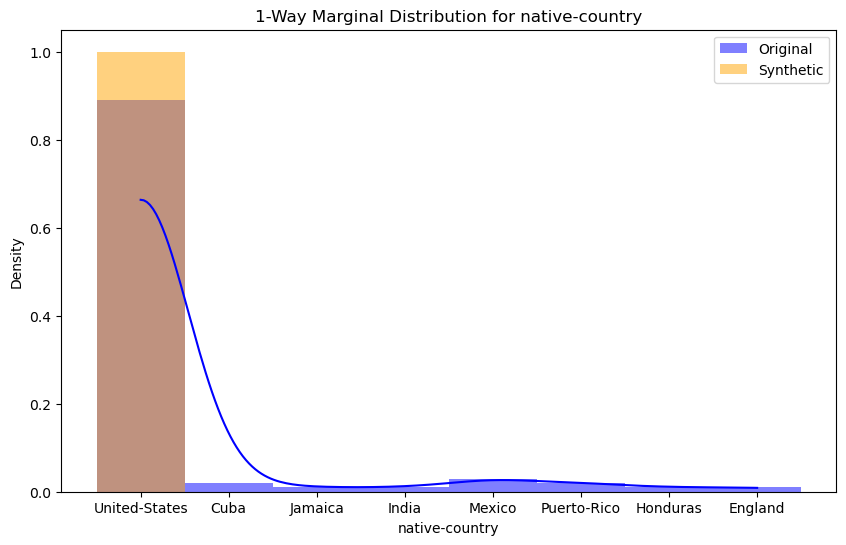


Statistics for native-country:
Original Data:
Cuba             0.02
England          0.01
Honduras         0.01
India            0.01
Jamaica          0.01
Mexico           0.03
Puerto-Rico      0.02
United-States    0.89
Name: native-country, dtype: float64

Synthetic Data:
United-States    1.0
Name: native-country, dtype: float64

Distribution difference:
Mean absolute difference: 0.0275
Maximum difference: 0.1100


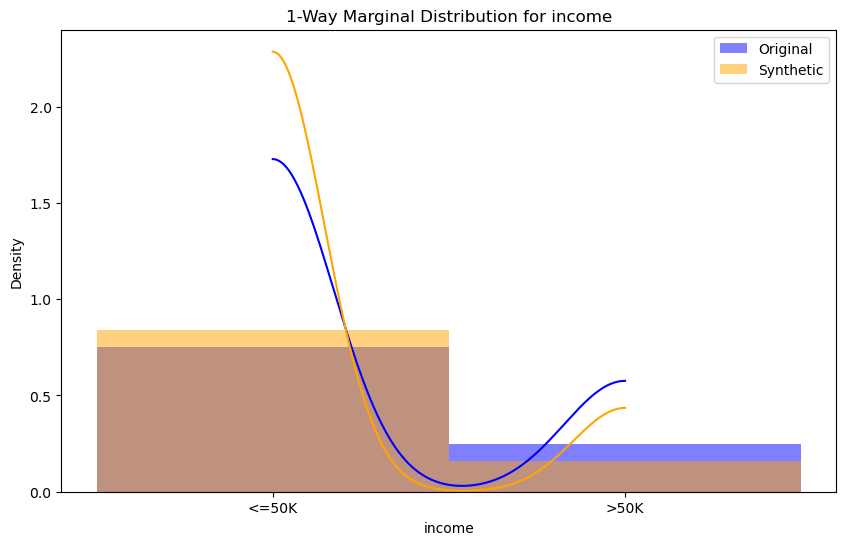


Statistics for income:
Original Data:
<=50K    0.75
>50K     0.25
Name: income, dtype: float64

Synthetic Data:
<=50K    0.84
>50K     0.16
Name: income, dtype: float64

Distribution difference:
Mean absolute difference: 0.0900
Maximum difference: 0.0900


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np

# Load original CSV data
original_data = pd.read_csv('adult100.csv')

# Convert generated dictionary list to DataFrame
with open('complete_json.json', 'r', encoding='utf-8') as f:
    complete_json = json.load(f)
synthetic_data = pd.DataFrame(complete_json)

def plot_1_way_marginal(original_data, synthetic_data, column):
    """
    Plot 1-way marginal distribution comparison between original and synthetic data
    
    Args:
        original_data (pd.DataFrame): Original dataset
        synthetic_data (pd.DataFrame): Synthetic dataset
        column (str): Column name to plot
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(original_data[column], color='blue', label='Original', kde=True, stat="density", linewidth=0)
    sns.histplot(synthetic_data[column], color='orange', label='Synthetic', kde=True, stat="density", linewidth=0)
    plt.title(f'1-Way Marginal Distribution for {column}')
    plt.legend()
    plt.show()
    
def calculate_statistics(original_data, synthetic_data, column):
    """
    Calculate and compare statistical metrics between original and synthetic data
    
    Args:
        original_data (pd.DataFrame): Original dataset
        synthetic_data (pd.DataFrame): Synthetic dataset
        column (str): Column name to analyze
    """
    if column in synthetic_data.columns:
        print(f"\nStatistics for {column}:")
        print("Original Data:")
        print(original_data[column].value_counts(normalize=True).sort_index())
        print("\nSynthetic Data:")
        print(synthetic_data[column].value_counts(normalize=True).sort_index())
        
        # Calculate distribution differences
        original_dist = original_data[column].value_counts(normalize=True)
        synthetic_dist = synthetic_data[column].value_counts(normalize=True)
        
        # Ensure both distributions have same indices
        all_categories = set(original_dist.index) | set(synthetic_dist.index)
        original_dist = original_dist.reindex(all_categories, fill_value=0)
        synthetic_dist = synthetic_dist.reindex(all_categories, fill_value=0)
        
        # Calculate differences
        diff = np.abs(original_dist - synthetic_dist)
        print(f"\nDistribution difference:")
        print(f"Mean absolute difference: {diff.mean():.4f}")
        print(f"Maximum difference: {diff.max():.4f}")

# Compare each feature
for column in original_data.columns:
    if column in synthetic_data.columns:  # Ensure feature exists in synthetic data
        plot_1_way_marginal(original_data, synthetic_data, column)
        calculate_statistics(original_data, synthetic_data, column)

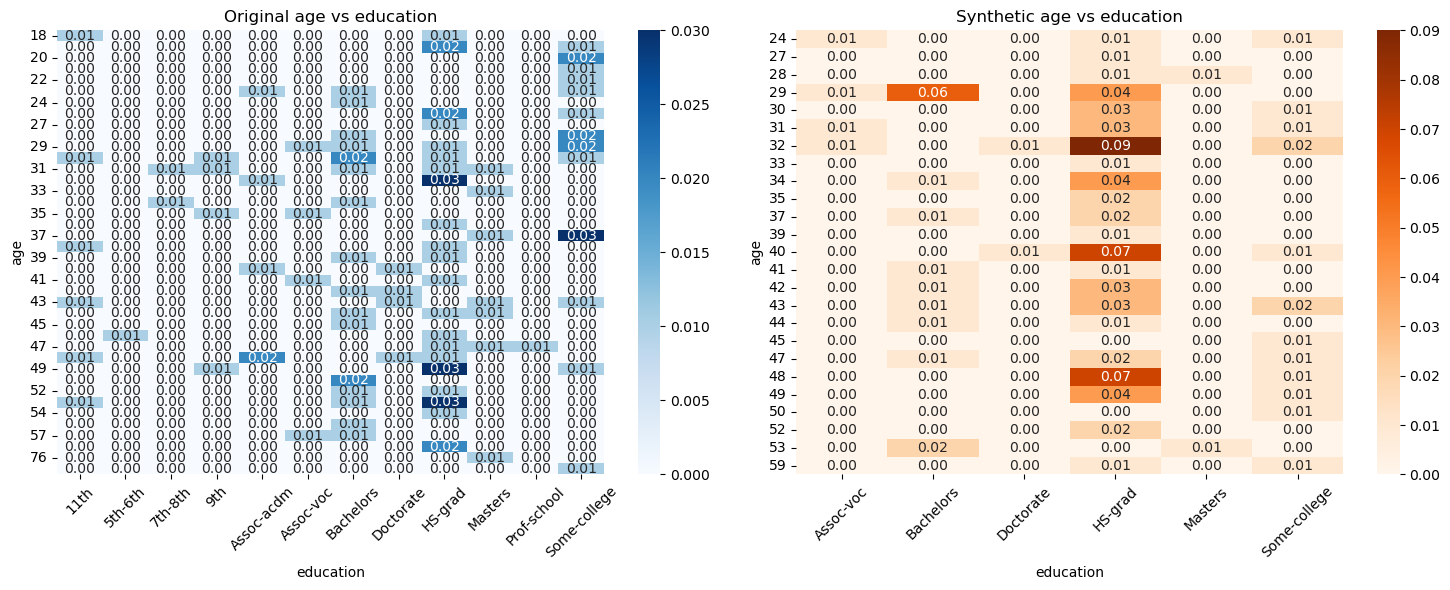


Distribution difference for age vs education:
Mean absolute difference: 0.0070
Maximum difference: 0.0700


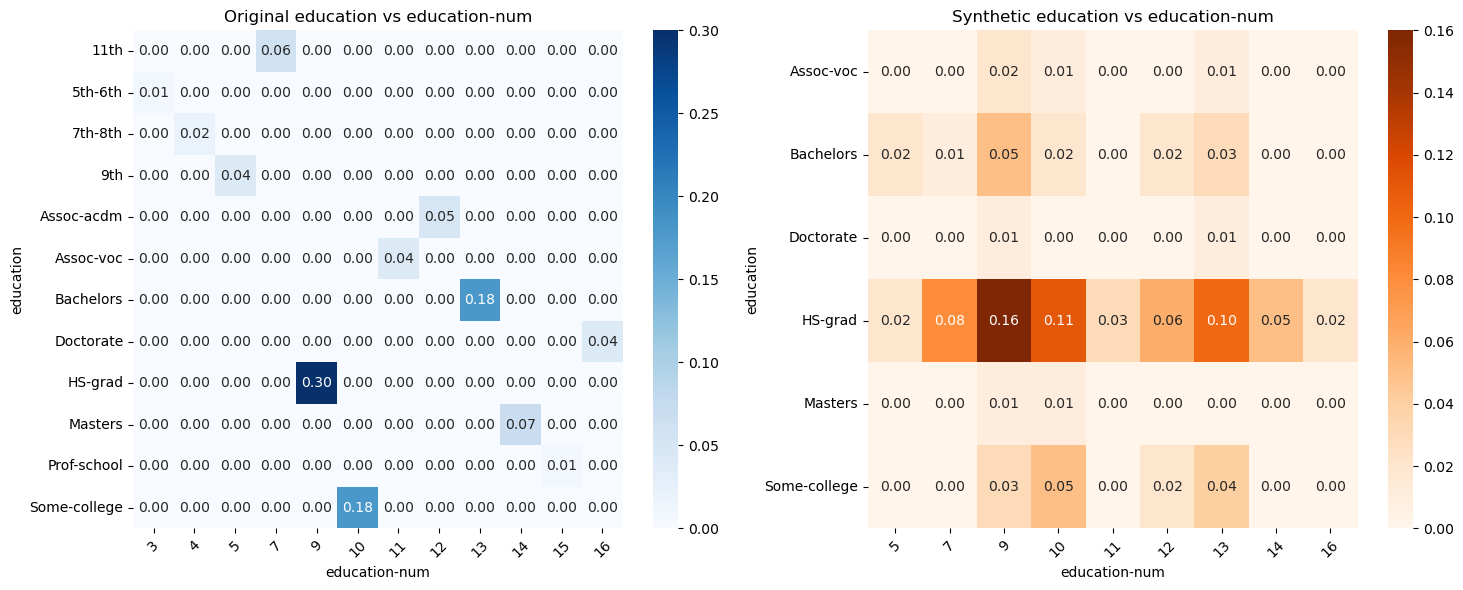


Distribution difference for education vs education-num:
Mean absolute difference: 0.0246
Maximum difference: 0.1500


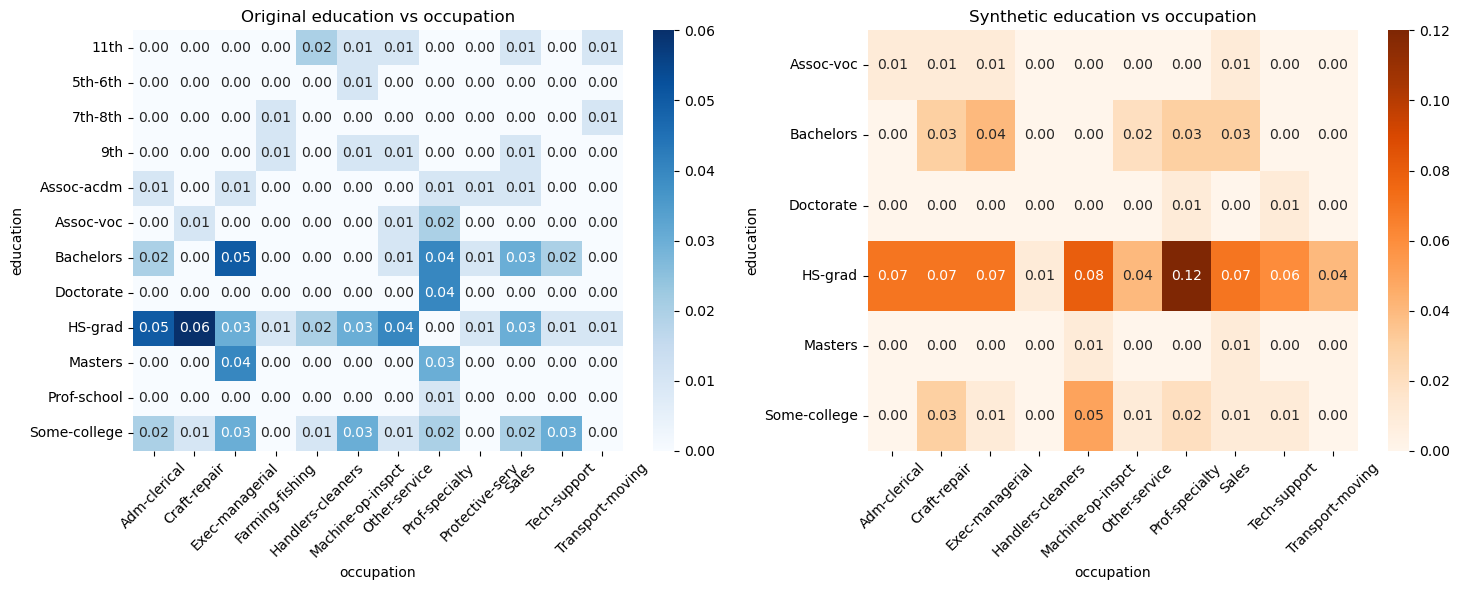


Distribution difference for education vs occupation:
Mean absolute difference: 0.0130
Maximum difference: 0.1200


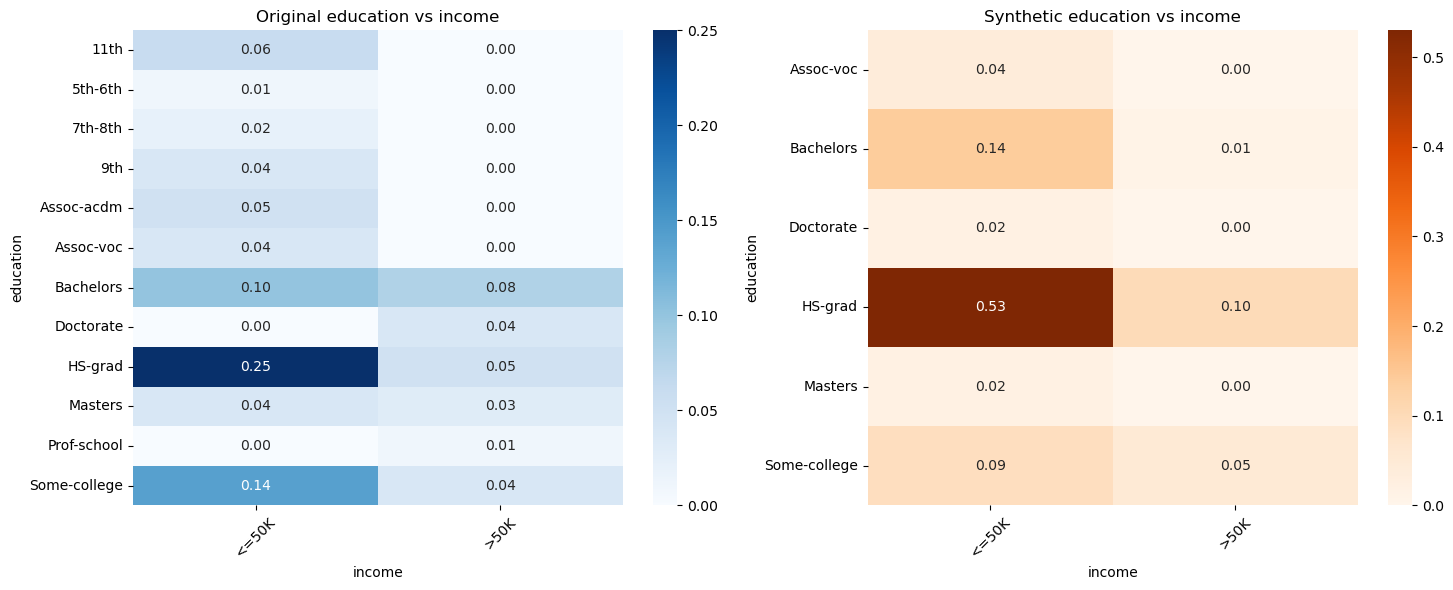


Distribution difference for education vs income:
Mean absolute difference: 0.0508
Maximum difference: 0.2800


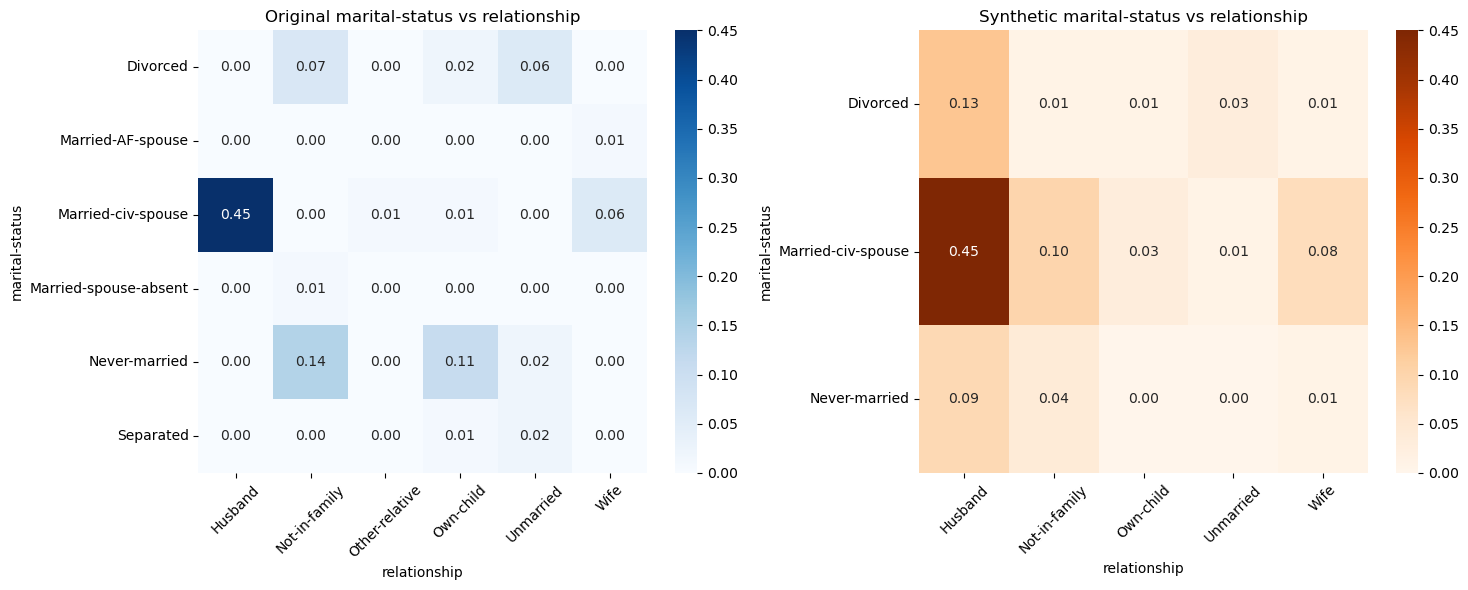


Distribution difference for marital-status vs relationship:
Mean absolute difference: 0.0480
Maximum difference: 0.1300


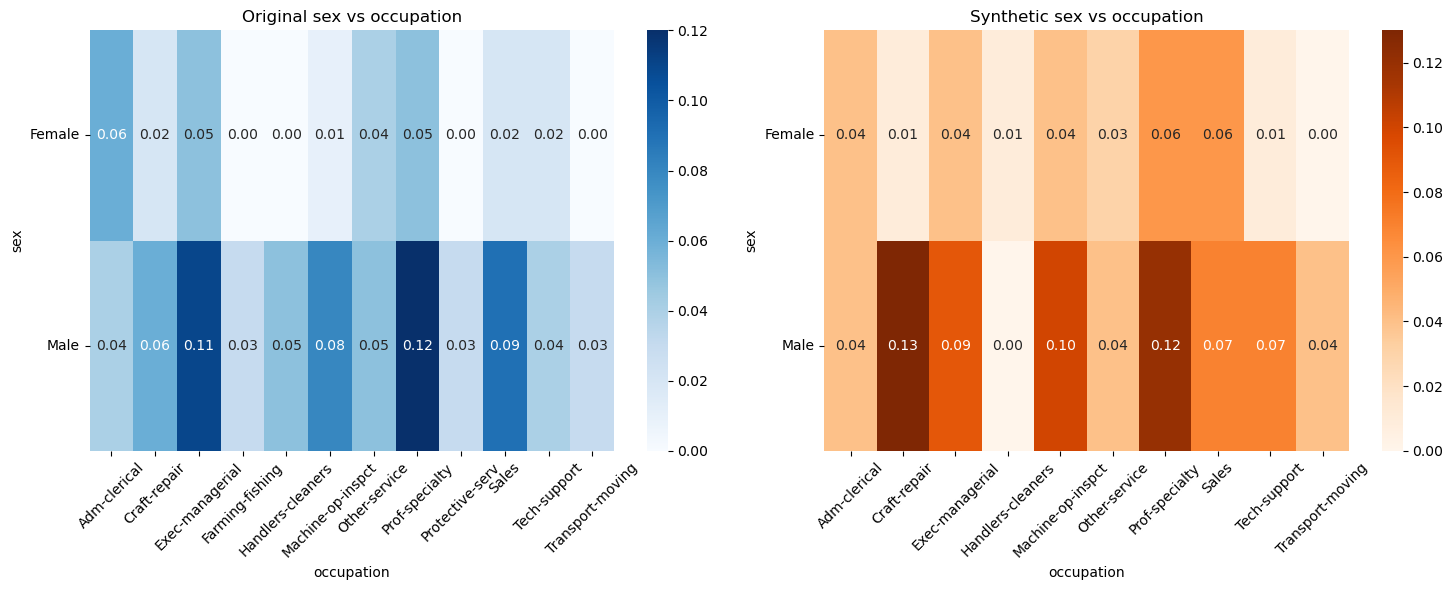


Distribution difference for sex vs occupation:
Mean absolute difference: 0.0190
Maximum difference: 0.0700


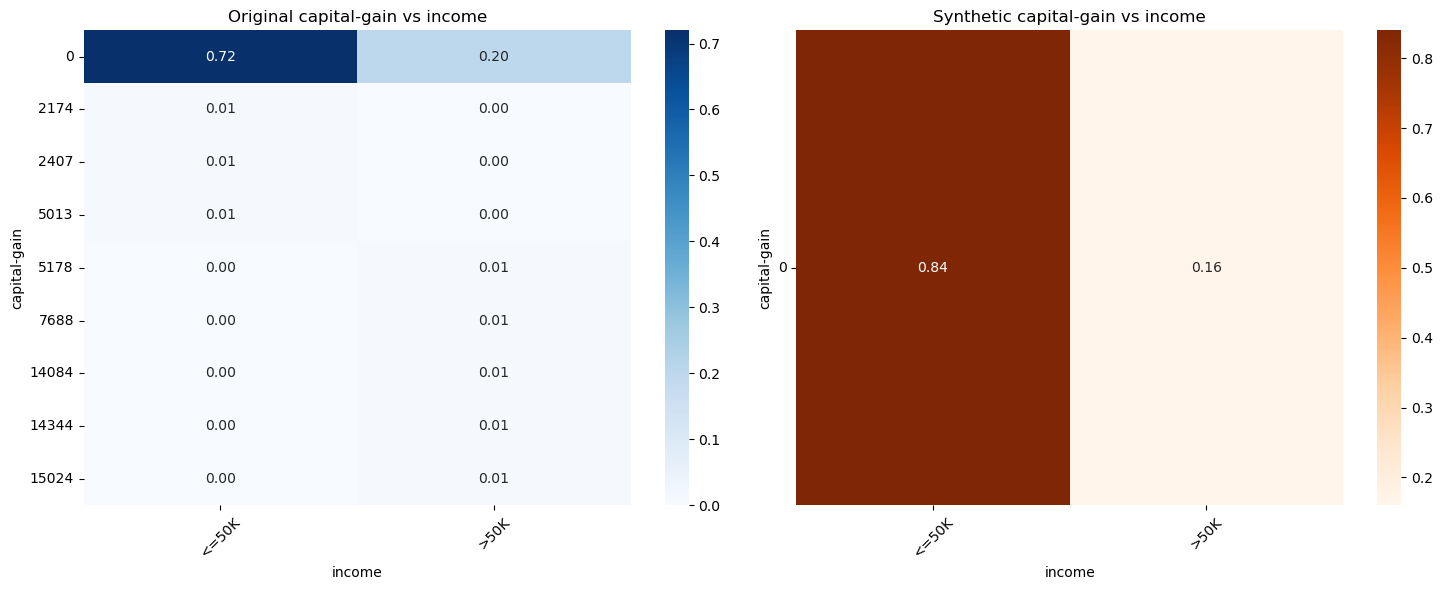


Distribution difference for capital-gain vs income:
Mean absolute difference: 0.0800
Maximum difference: 0.1200


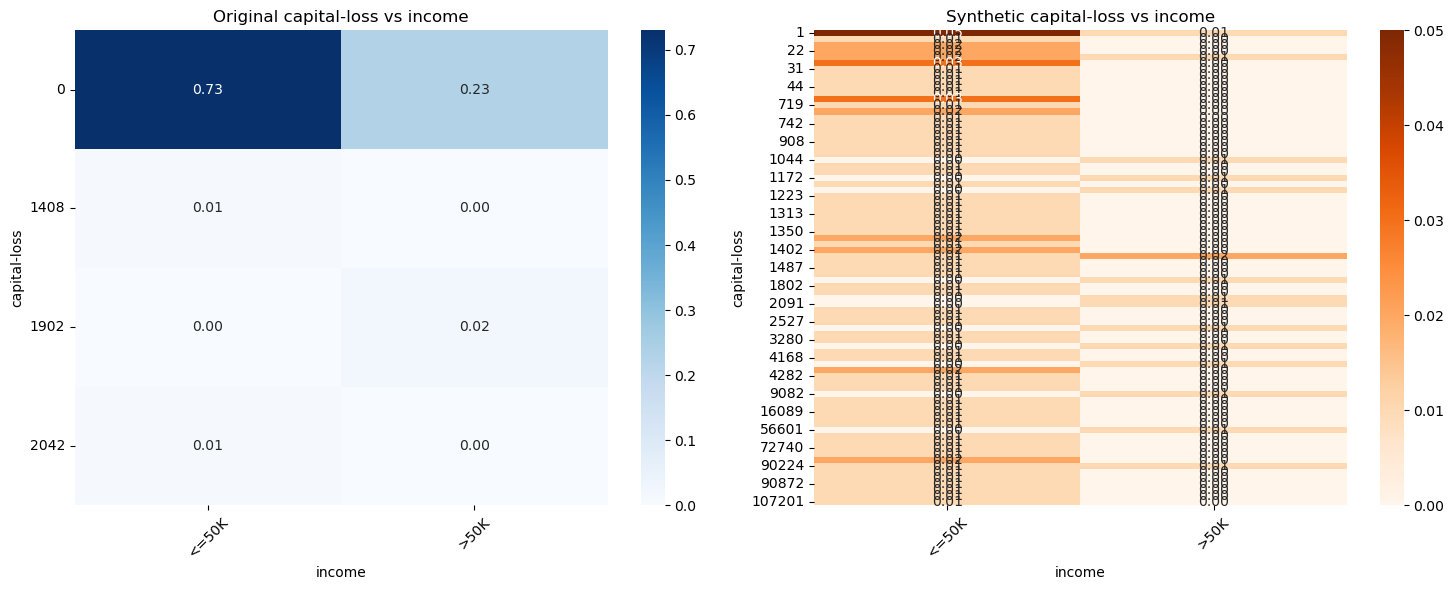


Distribution difference for capital-loss vs income:
Mean absolute difference: 0.0125
Maximum difference: 0.0200


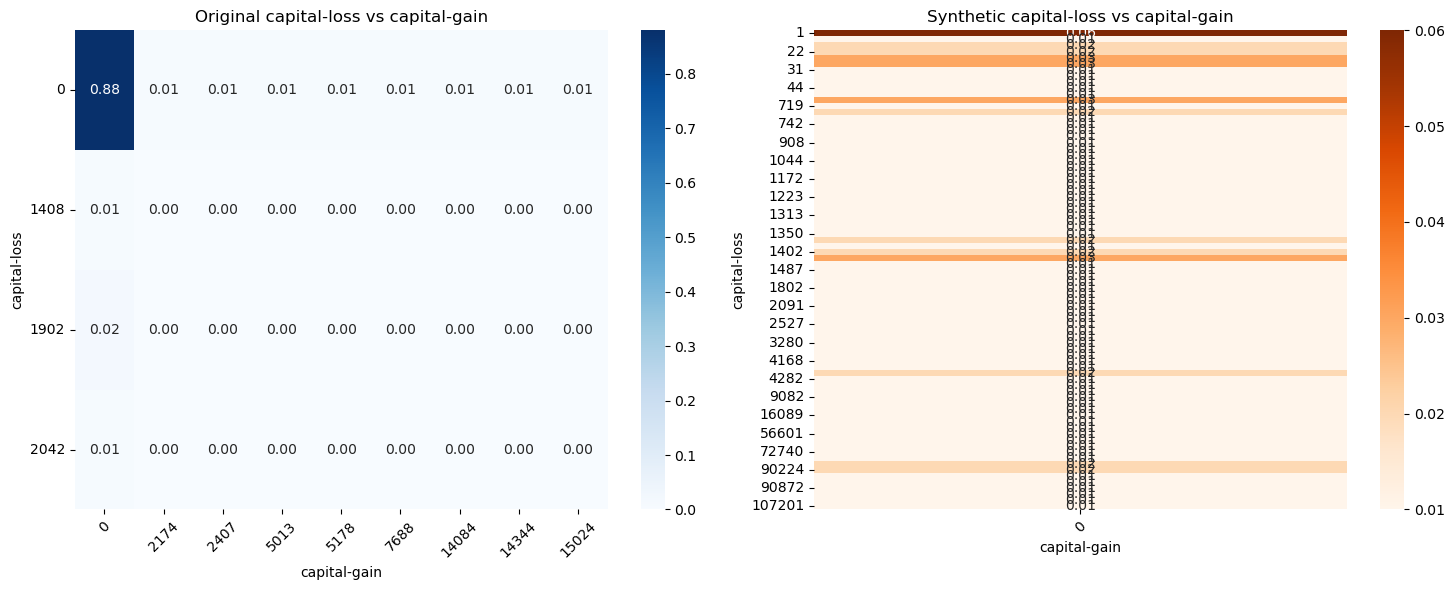


Distribution difference for capital-loss vs capital-gain:
Mean absolute difference: 0.0150
Maximum difference: 0.0200


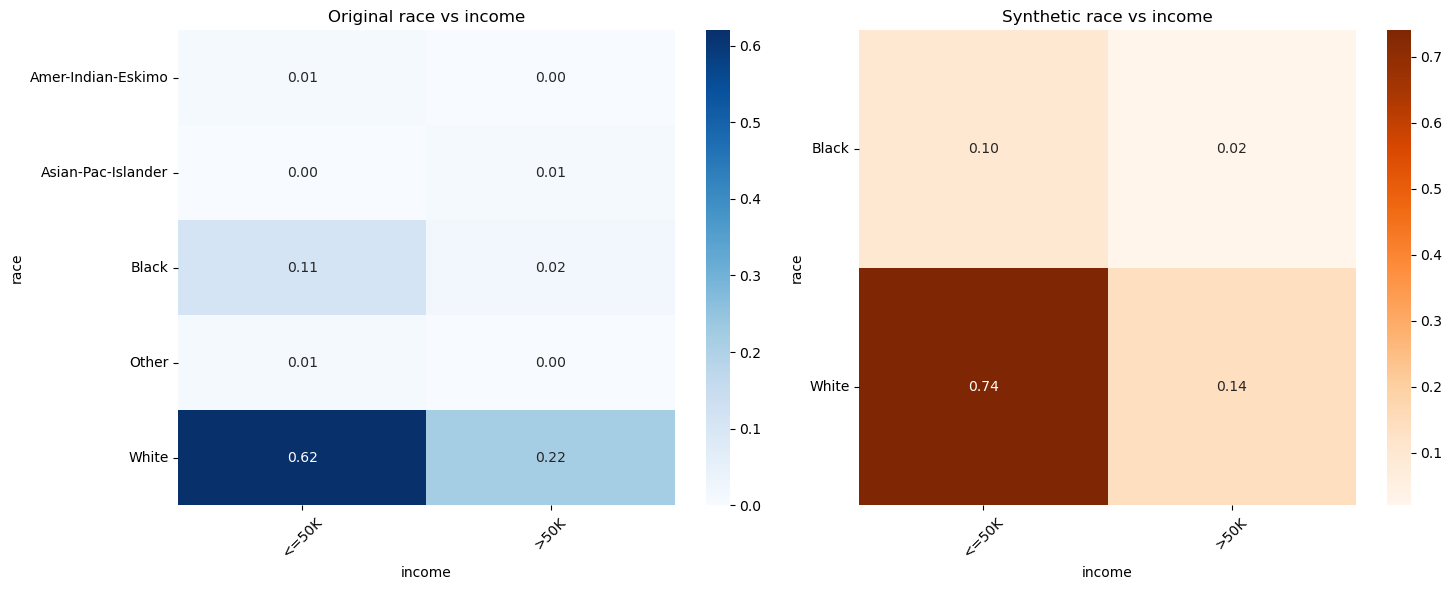


Distribution difference for race vs income:
Mean absolute difference: 0.0525
Maximum difference: 0.1200


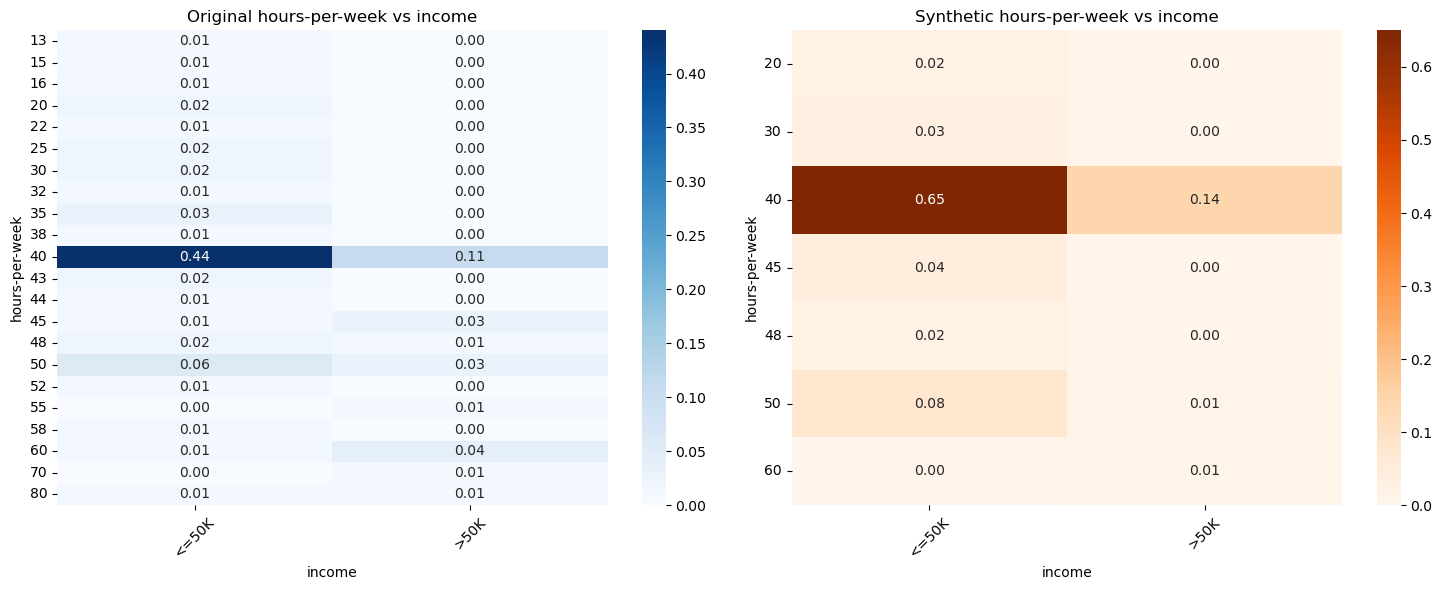


Distribution difference for hours-per-week vs income:
Mean absolute difference: 0.0286
Maximum difference: 0.2100


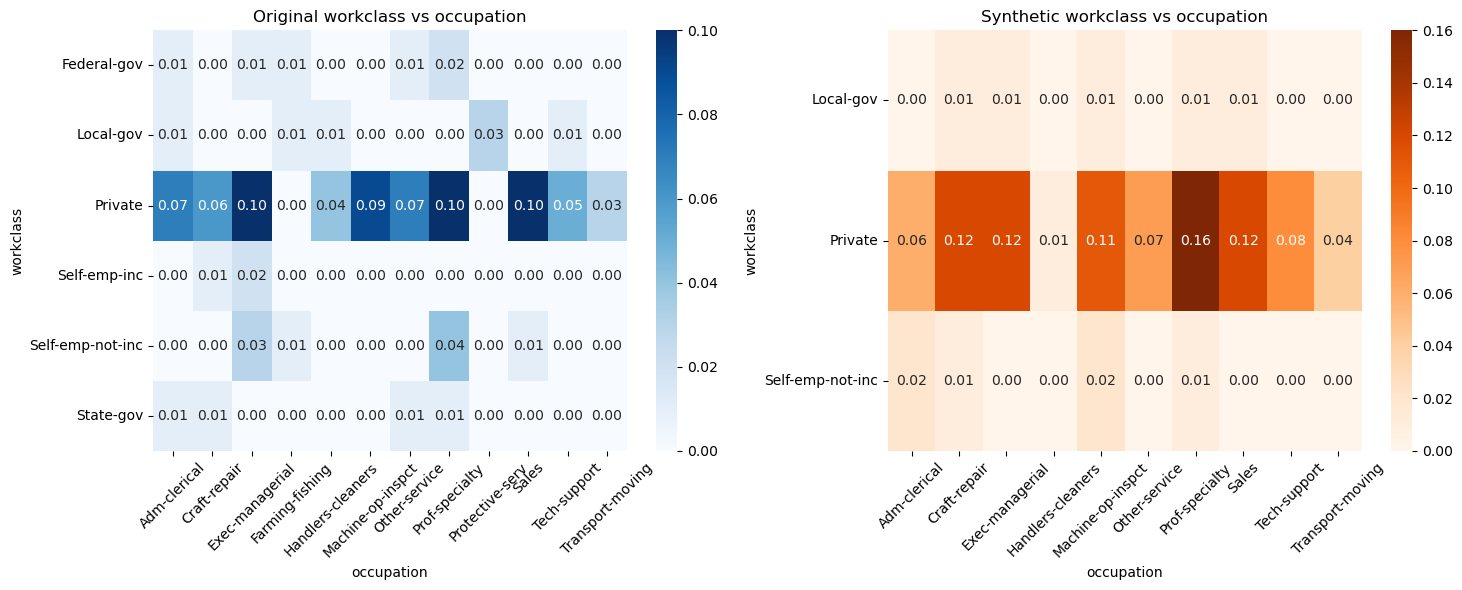


Distribution difference for workclass vs occupation:
Mean absolute difference: 0.0153
Maximum difference: 0.0600


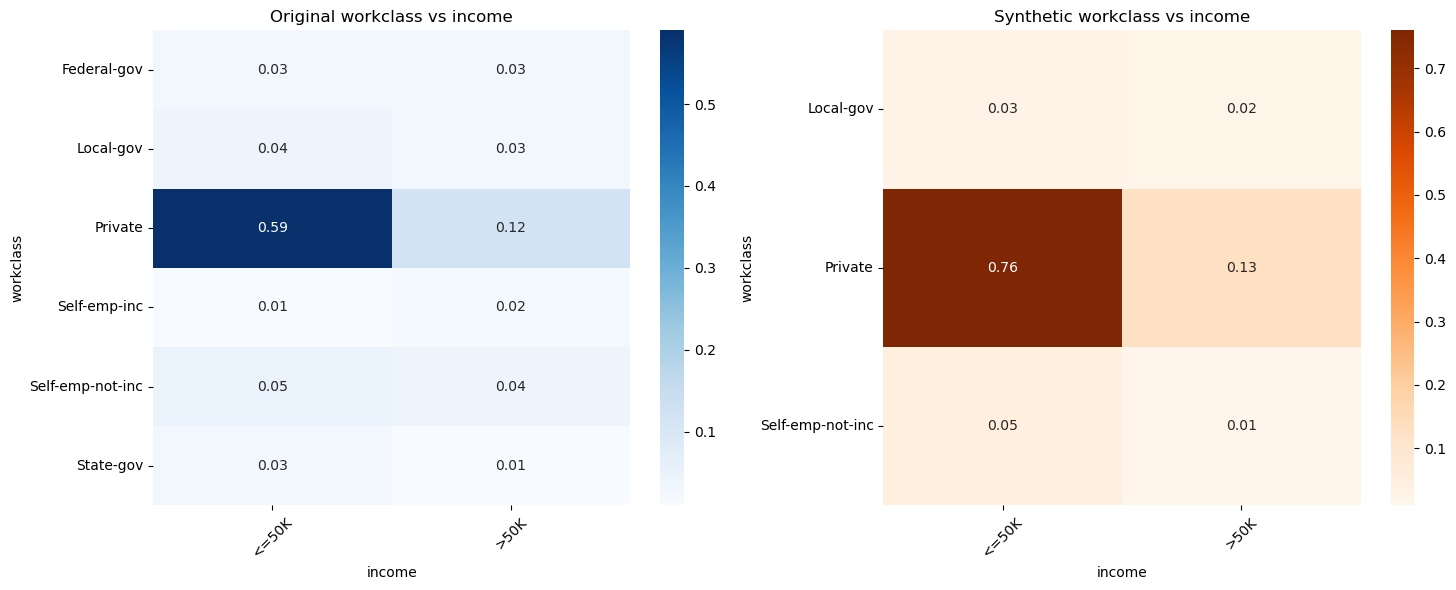


Distribution difference for workclass vs income:
Mean absolute difference: 0.0383
Maximum difference: 0.1700


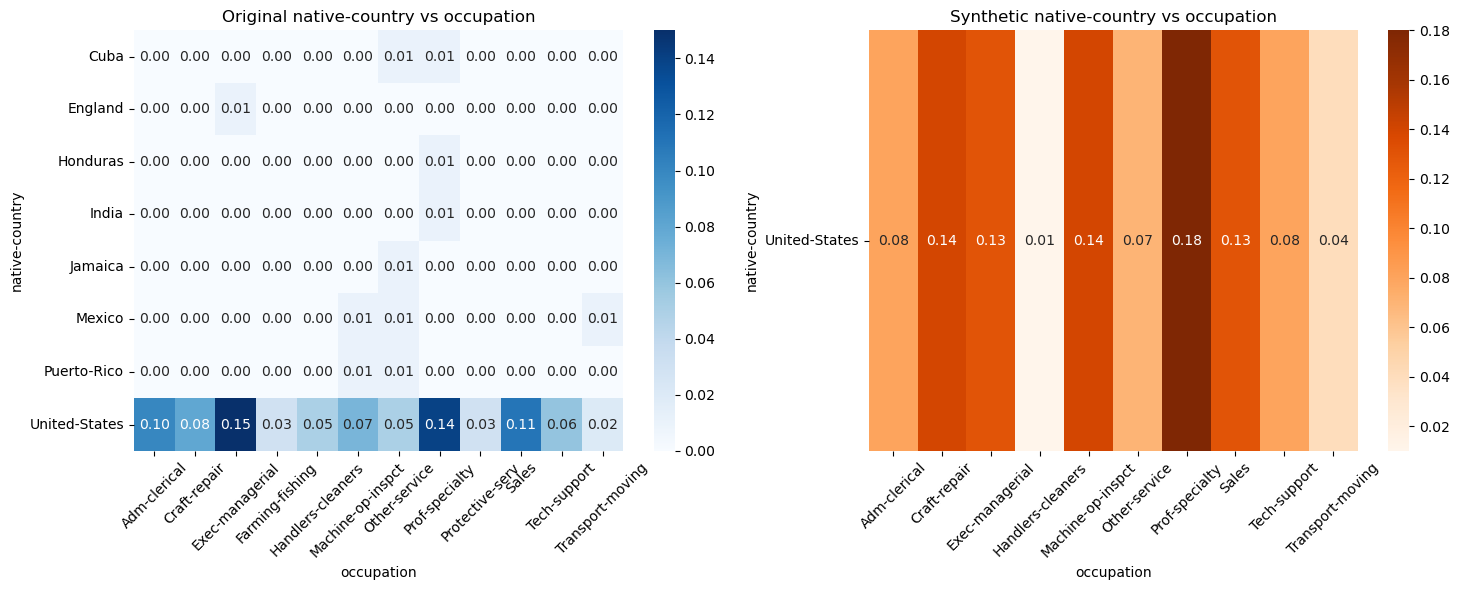


Distribution difference for native-country vs occupation:
Mean absolute difference: 0.0330
Maximum difference: 0.0700


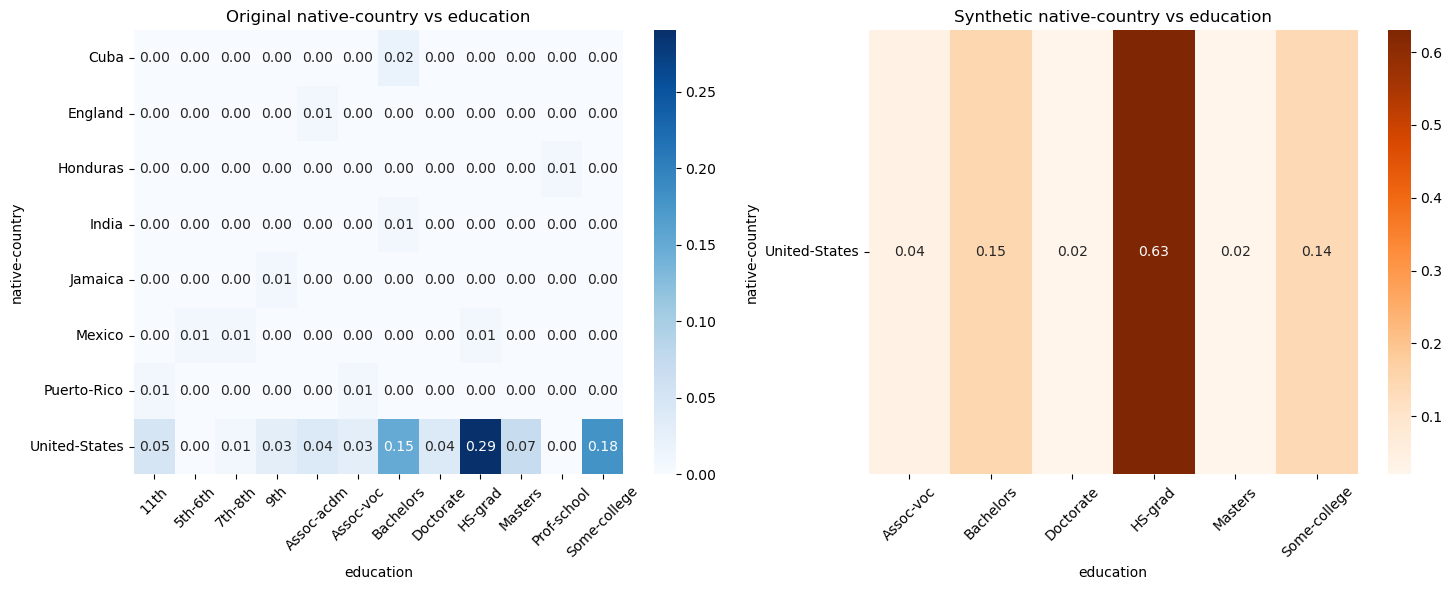


Distribution difference for native-country vs education:
Mean absolute difference: 0.0767
Maximum difference: 0.3400


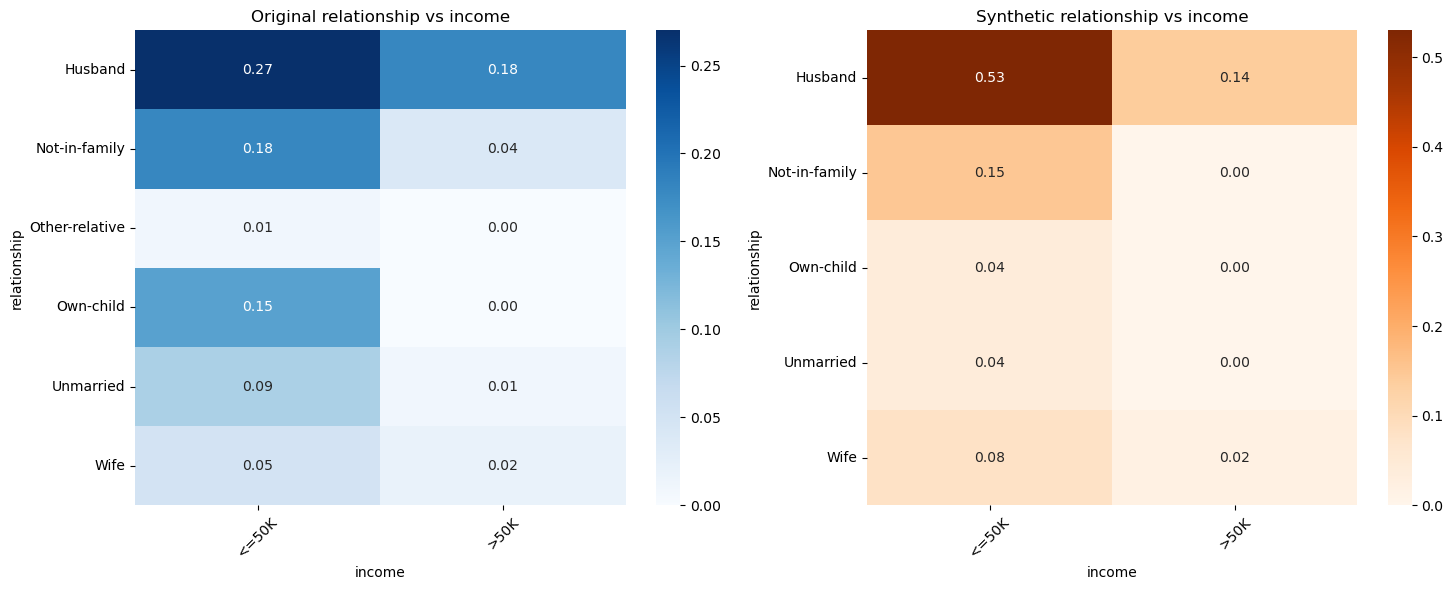


Distribution difference for relationship vs income:
Mean absolute difference: 0.0570
Maximum difference: 0.2600


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_2_way_marginal(original_data, synthetic_data, column1, column2):
    """
    Plot and compare 2-way marginal distributions between original and synthetic data
    
    Args:
        original_data (pd.DataFrame): Original dataset
        synthetic_data (pd.DataFrame): Synthetic dataset
        column1 (str): First column name
        column2 (str): Second column name
    """
    if column1 in synthetic_data.columns and column2 in synthetic_data.columns:
        plt.figure(figsize=(15, 6))
        
        # Calculate joint distributions
        original_joint = pd.crosstab(original_data[column1], original_data[column2], normalize='all')
        synthetic_joint = pd.crosstab(synthetic_data[column1], synthetic_data[column2], normalize='all')
        
        # Create subplots
        plt.subplot(1, 2, 1)
        sns.heatmap(original_joint, annot=True, fmt='.2f', cmap='Blues')
        plt.title(f'Original {column1} vs {column2}')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        
        plt.subplot(1, 2, 2)
        sns.heatmap(synthetic_joint, annot=True, fmt='.2f', cmap='Oranges')
        plt.title(f'Synthetic {column1} vs {column2}')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        
        plt.tight_layout()
        plt.show()
        
        # Calculate distribution differences
        diff = np.abs(original_joint - synthetic_joint)
        print(f"\nDistribution difference for {column1} vs {column2}:")
        print(f"Mean absolute difference: {diff.mean().mean():.4f}")
        print(f"Maximum difference: {diff.max().max():.4f}")

# Define feature pairs for comparison
# You can add extra ones
feature_pairs = [
    ('age', 'education'),
    ('education', 'education-num'),
    ('education', 'occupation'),
    ('education', 'income'),
    ('marital-status', 'relationship'),
    ('sex', 'occupation'),
    ('capital-gain', 'income'),
    ('capital-loss', 'income'),
    ('capital-loss', 'capital-gain'),
    ('race', 'income'),
    ('hours-per-week', 'income'),
    ('workclass', 'occupation'),
    ('workclass', 'income'),
    ('native-country', 'occupation'),
    ('native-country', 'education'),
    ('relationship', 'income')
]

# Plot 2-way marginal distributions for each feature pair
for column1, column2 in feature_pairs:
    plot_2_way_marginal(original_data, synthetic_data, column1, column2)